<a href="https://colab.research.google.com/github/lakshaygola/Cifar10-using-Resnet9-arch/blob/main/residualmodel_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('cifar10-residualmodel')
jovian.set_colab_id('1Cud0txRev7GcGWb3ut0mSjRYaUDjCZid')

     |████████████████████████████████| 71kB 4.8MB/s 


In [2]:
!pip install jovian --upgrade --quiet

In [3]:
project_name= 'cifar10-residualmodel'

In [4]:
# Importing necessary libaray
import torch
import torch.nn as nn
import torchvision as t
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import numpy as np
import pandas as pd
import tarfile
import os
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

%matplotlib inline

In [5]:
# Downloading the dataset
dataset_url= 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

In [6]:
# Extracting all the files in dataset
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [7]:
data_dir= './data/cifar10'
print(os.listdir(data_dir))
classes= os.listdir(data_dir+'/train')
print(classes)

['test', 'train']
['ship', 'frog', 'cat', 'airplane', 'automobile', 'bird', 'truck', 'deer', 'dog', 'horse']


In [8]:
# Loading the data after apply normalization and some random crop on the images
stats= ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_trans= t.transforms.Compose([t.transforms.RandomCrop(32, padding= 4, padding_mode='reflect'),
                          t.transforms.RandomHorizontalFlip(), 
                          t.transforms.ToTensor(), 
                          t.transforms.Normalize(*stats, inplace= True)])
val_trans= t.transforms.Compose([t.transforms.ToTensor(),
                        t.transforms.Normalize(*stats, inplace= True)])

In [9]:
train_data= ImageFolder(data_dir+'/train', transform= train_trans)
test_data= ImageFolder(data_dir+'/test', transform= val_trans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  0


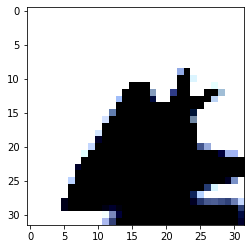

In [10]:
image, label= train_data[0]
plt.imshow(image.permute(1,2,0))
print('label: ', label)

In [11]:
# Denorm function to remove the normalization from the image
def denorm(image, mean, std):
  means= torch.tensor(mean).reshape(1,3,1,1)
  std= torch.tensor(std).reshape(1,3,1,1)
  return image * std + means

# Show grid function to show the image of the dataset in a grid
def show_grid(batch):
  for image, label in batch:
    fig, ax= plt.subplots(figsize= (12,11))
    ax.imshow(make_grid(denorm(image, *stats), nrow= 20).permute(1,2,0))
    break

In [12]:
# Lets crete the batch of the data
batch_size= 120
train_loader= DataLoader(train_data, batch_size, shuffle= True, num_workers=4, pin_memory=True)
val_loader= DataLoader(test_data, batch_size*2, pin_memory= True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


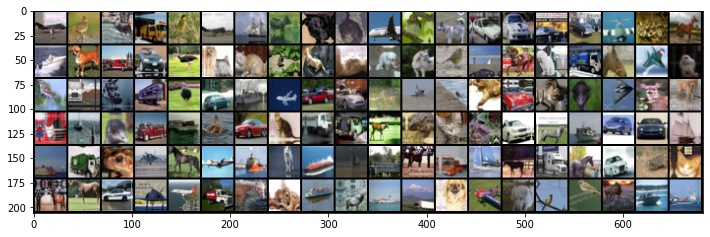

In [13]:
show_grid(train_loader)

# GPUs Function

In [14]:
def get_device():
  if torch.cuda.is_available:
    return ('cuda')
  else:
    return ('cpu')

def to_device(data, device):
  if isinstance(data, (tuple, list)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking= True)

class DeviceDataLoader():
  def __init__(self, batch,device):
    self.dl= batch
    self.device= device

  def __iter__(self):
    for b in self.dl:
      yield to_device (b, self.device)

  def __len__(self):
    return len(self.dl)

# Image Classification function and Classes

In [15]:
def accuracy(outputs, label):
  _, preds= torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==label).item()/len(preds))

class ImageClassifcationBase(nn.Module):
  
  # Calcuate the loss for the training dataset
  def training_step(self, batch):
    image, label= batch
    out= self(image)
    loss= F.cross_entropy(out, label)
    return loss

  # Calculating the loss and the accuracy for the validation dataset

  def validation_step(self, batch):
    image, label= batch
    out= self(image)
    loss= F.cross_entropy(out, label)
    acc= accuracy(out, label)
    return {'validation_loss': loss.detach(), 'validation_accuracy': acc}

  # Combining the loss and the accuracy

  def validation_epochsend(self, outputs):
    batch_loss= [x['validation_loss'] for x in outputs]
    loss= torch.stack(batch_loss).mean().item()
    batch_acc= [x['validation_accuracy'] for x in outputs]
    accuracy= torch.stack(batch_acc).mean().item()
    return {'validation_loss': loss, 'validation_accuracy': accuracy}

  # To print the result

  def epochs_end(self, result, epoch):
    print('Epochs: [{}], training loss: {:.4f}, validation loss: {:.4f}, validation accuracy: {:.4f}'.format(
        epoch, result['train_loss'], result['validation_loss'], result['validation_accuracy']
    ))

In [16]:
# In this function we are definig the layer of the model
def conv_block(inchannel,outchannel, pool=False):
  layers= [nn.Conv2d(inchannel, outchannel, kernel_size=3, padding= 1), 
                        nn.BatchNorm2d(outchannel), 
                        nn.ReLU(inplace= True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

In [17]:
# Making the resnet model
class Resnet9(ImageClassifcationBase):
  def __init__(self, inchannel, outchannel):
    super().__init__()
  
    # Making layers for the model
    self.conv1= conv_block(inchannel, 64)
    self.conv2= conv_block(64, 128, pool= True)
    self.res1= nn.Sequential(conv_block(128,128), 
                             conv_block(128,128))
    
    self.conv3= conv_block(128,256, pool= True)
    self.conv4= conv_block(256,512, pool= True)
    self.res2= nn.Sequential(conv_block(512,512), 
                             conv_block(512,512))
    
    # Flatten out the data and then pass into Linear function
    
    self.classifier= nn.Sequential(nn.MaxPool2d(4),
                                   nn.Flatten(),
                                   nn.Dropout(0.2),
                                   nn.Linear(512, num_classes))
    
  # forward function to apply these function to the data
  def forward(self, xb):
    out= self.conv1(xb)
    out= self.conv2(out)
    out= self.res1(out) + out
    out= self.conv3(out)
    out= self.conv4(out)
    out= self.res2(out) + out
    out= self.classifier(out)

    return out

In [18]:
# Definig number of input and the outputs
inchannel= 3
num_classes= 10

In [19]:
# Getting the avialable device
device= get_device()
device

'cuda'

In [20]:
# Moving batches of the data on given device
train_loader= DeviceDataLoader(train_loader, device)
val_loader= DeviceDataLoader(val_loader, device)

In [21]:
# Creating the model
model= to_device(Resnet9(inchannel, num_classes), device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# Saving the work
import jovian
jovian.commit(project= project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

# Training the model

In [ ]:
# Evaluation model 
def evaluate(model, val_loader):
  model.eval()
  outputs= [model.validation_step(batch) for batch in val_loader]
  return model.validation_epochsend(outputs)

# To trace the learning rate 
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


# defining the fit model to train the model
def fit(epochs, lr, model, train_loader, val_loader, weight_decay= 0, grad_clip= None, optimizer=torch.optim.SGD):

  torch.cuda.empty_cache()

  history= []                 # To trace the progress
  train_loss= []

  opt= optimizer(model.parameters(), lr, weight_decay= weight_decay)

  # Schedular to change the learning rate after each epoch
  sch= torch.optim.lr_scheduler.OneCycleLR(opt, lr, epochs= epochs, steps_per_epoch= len(train_loader))

  for epoch in range(epochs):
    lr=[]
    model.train()

    # Training Phase
    for batch in train_loader:
      loss= model.training_step(batch)
      train_loss.append(loss)

      loss.backward()

      # Apply gradient decent on the graident we get after backward method
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      
      opt.step()
      opt.zero_grad()

      lr.append(get_lr(opt))

      sch.step()

    # Validation Phase
    result= evaluate(model, val_loader)
    result['train_loss']= torch.stack(train_loss).mean().item()
    result['lr']= lr
    model.epochs_end(result, epoch)

    history.append(result)
  return history

In [ ]:
history= [evaluate(model, val_loader)]
history

[{'validation_accuracy': 0.12410715967416763,
  'validation_loss': 2.301802158355713}]

Randomly getting 10% accuracy of the model intially.

In [ ]:
# Definig the hyperparameter used in train the model
opt_func= torch.optim.Adam
lr= 0.001
weight_decay= 1e-4
grad_clip= 0.1
epochs= 10

In [ ]:
# Now training the model
%%time
history = fit(epochs, lr, model, train_loader, val_loader, weight_decay, grad_clip, opt_func)

Epochs: [0], training loss: 1.5870, validation loss: 1.0534, validation accuracy: 0.6180
Epochs: [1], training loss: 1.3288, validation loss: 0.9612, validation accuracy: 0.6639
Epochs: [2], training loss: 1.1605, validation loss: 0.7113, validation accuracy: 0.7548
Epochs: [3], training loss: 1.0392, validation loss: 0.5940, validation accuracy: 0.7994
Epochs: [4], training loss: 0.9420, validation loss: 0.4985, validation accuracy: 0.8279
Epochs: [5], training loss: 0.8644, validation loss: 0.4676, validation accuracy: 0.8351
Epochs: [6], training loss: 0.7971, validation loss: 0.4438, validation accuracy: 0.8543
Epochs: [7], training loss: 0.7370, validation loss: 0.3239, validation accuracy: 0.8898
Epochs: [8], training loss: 0.6830, validation loss: 0.2788, validation accuracy: 0.9071
Epochs: [9], training loss: 0.6363, validation loss: 0.2690, validation accuracy: 0.9105
CPU times: user 1min 33s, sys: 12.9 s, total: 1min 46s
Wall time: 5min 51s


In [ ]:
train_time= '5min 40s'

In [ ]:
# Plotting the accuracy of the model
def show_accuracy(history):
  accuracies= [x['validation_accuracy'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('Epoches')
  plt.ylabel('Accuracy')
  plt.title('Accuracy of the model')

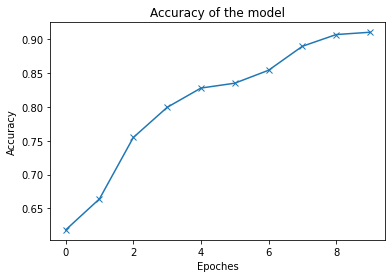

In [ ]:
show_accuracy(history)

In [ ]:
# Plotting the validation loss and the accuracy of the loss
def loss_compare(history):
  train_loss= [x['train_loss'] for x in history]
  val_loss= [x['validation_loss'] for x in history]
  plt.plot(train_loss, '-x')
  plt.plot(val_loss, '-x')
  plt.xlabel('Epoches')
  plt.ylabel('Losses')
  plt.legend(['training loss', 'validation loss'])
  plt.title('Loss tracking of the model')

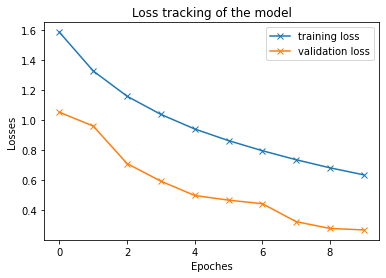

In [ ]:
loss_compare(history)

In [ ]:
import numpy as np

In [ ]:
# Function to trace the learning rate of the model
def lr_trace(history):
  lrs= np.concatenate([x.get('lr', []) for x in history])
  plt.plot(lrs, '-x')
  plt.xlabel('Epoches')
  plt.ylabel('Learning rate')
  plt.title('Learning rate trace')

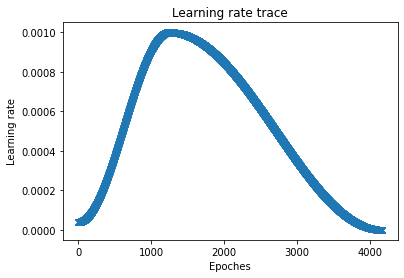

In [ ]:
lr_trace(history)

# Taking the prediction on the test dataset


In [ ]:
# Function to take prediction from the model
def predict(images, model):
  xb= to_device(images.unsqueeze(0), device)
  yb= model(xb)
  _, preds= torch.max(yb, dim=1)
  return train_data.classes[preds[0].item()]

TypeError: ignored

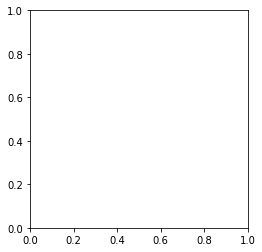

In [ ]:
# Example 1
image, label= test_data[1025]
plt.imshow(image.permute(1,2,0).clamp())
print('Predicted: ', predict(image, model), 'Label: ', test_data.classes[label])

In [ ]:
# Example 2
image, label= test_data[105]
plt.imshow(image.permute(1,2,0).clamp(0,1))
print('Predicted: ', predict(image, model), 'Label: ', test_data.classes[label])

In [ ]:
# Saving the hyper parameters
jovian.log_hyperparams(batch_size= batch_size,
                       learning_rate= lr,
                       No_of_epoches= epochs,
                       training_time= train_time,
                       weight_decay= weight_decay, 
                       grad_clip= grad_clip, 
                       opt= opt_func.__name__, 
                       schedular= 'One Cycle')

In [ ]:
# Taking record of accuracy and the loss of the model
jovian.log_metrics(validation_loss= history[-1]['validation_loss'],
                   validation_accuracy= history[-1]['validation_accuracy'],
                   training_loss= history[-1]['train_loss'],
                   time= train_time)

In [ ]:
# Saving the weigth of the models in cifar10resnet file
torch.save(model.state_dict(), 'cifar10resnet.pth')

In [ ]:
jovian.commit(project= project_name, environment= None, outputs=['cifar10resnet.pth'])